In [27]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [3]:
bc_deaths = pd.read_csv('../data/processed/British Columbia_combined.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
bc_deaths

,daily_deaths
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2022-01-16,0.0
2022-01-17,22.0
2022-01-18,2.0


<AxesSubplot:xlabel='Date'>

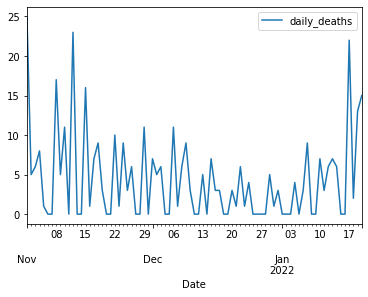

In [5]:
bc_deaths['2021-11-01':].plot()

In [24]:
#bc_deaths.replace([np.inf, -np.inf], value=0, inplace=True)
ds = bc_deaths.isin([np.inf, -np.inf])
print(ds)

            daily_deaths  daily_deaths_log
Date                                      
2020-01-22         False              True
2020-01-23         False              True
2020-01-24         False              True
2020-01-25         False              True
2020-01-26         False              True
...                  ...               ...
2022-01-16         False              True
2022-01-17         False             False
2022-01-18         False             False
2022-01-19         False             False
2022-01-20         False             False

[730 rows x 2 columns]


### Check for stationarity

<Figure size 432x288 with 0 Axes>

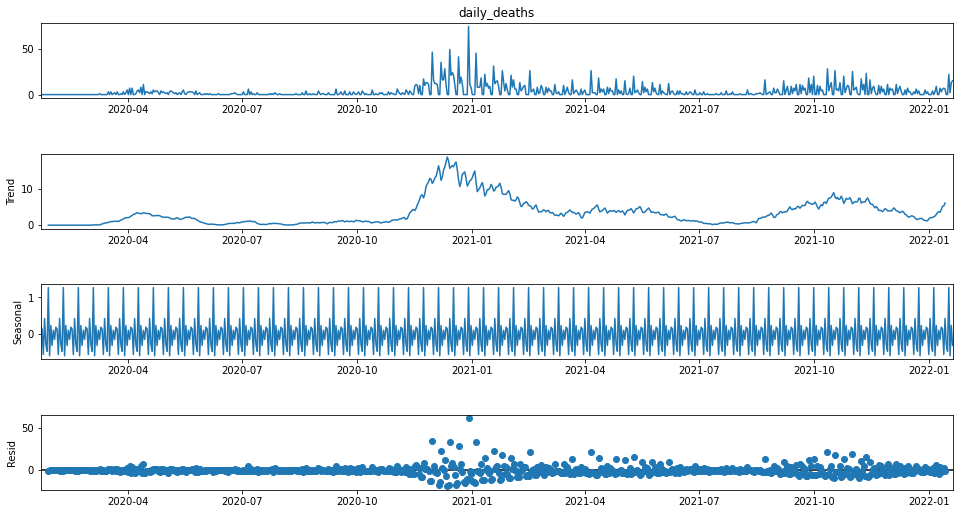

In [6]:
decomposition = seasonal_decompose(bc_deaths.daily_deaths, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    ewm_avg = timeseries.ewm(alpha=0.3, adjust=False).mean()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    ewm = plt.plot(ewm_avg, color='orange', label = 'ewm')
    plt.legend(loc='best')
    plt.title('Rolling Mean, Standard Deviation and ewm')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

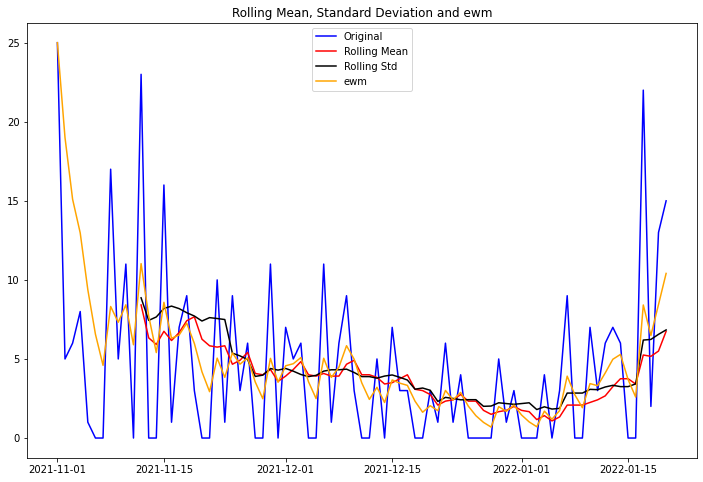

Results of Dickey-Fuller Test:
Test Statistic                 -0.647037
p-value                         0.859995
#Lags Used                      6.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [8]:
subset=bc_deaths['2021-11-01':]
test_stationarity(subset.daily_deaths)

Null hypothesis for Dickey Fuller Test is that the series is non stationary. Hence, alternate hypothesis is, series is stationary.

Here, p value (.85) is not less than .05. Also, t value is not less than critical values. Hence we cant reject null hypothesis. The series is non stationary. Lets see how we can make it stationary.

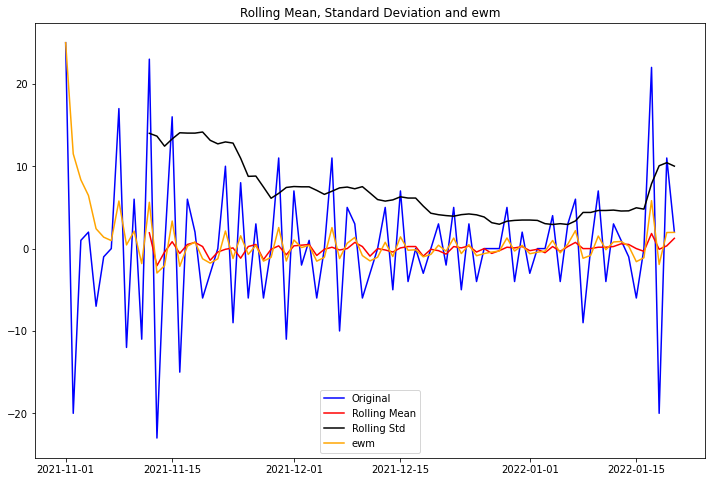

Results of Dickey-Fuller Test:
Test Statistic                -8.619242e+00
p-value                        6.169200e-14
#Lags Used                     5.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


In [26]:

bc_deaths['first_difference'] = bc_deaths.daily_deaths - bc_deaths.daily_deaths.shift(1)  
subset=bc_deaths['2021-11-01':]
test_stationarity(subset.first_difference.dropna(inplace=False))

### Plot the ACF and PACF charts and find the optimal parameters


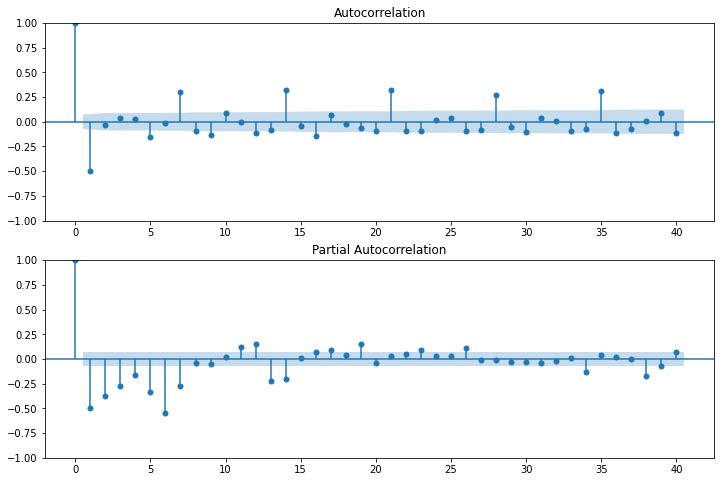

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(bc_deaths.first_difference.iloc[1:], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(bc_deaths.first_difference.iloc[1:], lags=40, ax=axes[1])

In [9]:
dataset = bc_deaths.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

694

In [10]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)